In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import f_oneway

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols


%matplotlib inline

In [5]:
### Load losses
base_loss = pd.read_pickle("./weights/elia-base-transformer-freqD-layers2-heads4-fe256_test_losses.pkl")
causal_loss = pd.read_pickle("./weights/elia-causal-conv-transformer-freqD-layers2-heads4-fe256-ks9_test_losses.pkl")
asym_loss = pd.read_pickle("./weights/elia-asym-conv-transformer-freqD-layers2-heads4-fe256-ks3_test_losses.pkl")
fourier_loss = pd.read_pickle("./weights/elia-fourier-transformer-freqD-layers2-heads4-fe256_test_losses.pkl")

base_loss = base_loss.squeeze().to_numpy()
causal_loss = causal_loss.squeeze().to_numpy()
asym_loss = asym_loss.squeeze().to_numpy()
fourier_loss = fourier_loss.squeeze().to_numpy()

df = pd.DataFrame({
    'loss': pd.concat([pd.Series(base_loss), pd.Series(causal_loss), pd.Series(asym_loss), pd.Series(fourier_loss)], ignore_index=True),
    'group': ['AM-1']*len(base_loss) + ['AM-2']*len(causal_loss) + ['AM-3']*len(asym_loss) + ['AM-4']*len(fourier_loss)
})

### ANOVA Assumptions
#### Normality

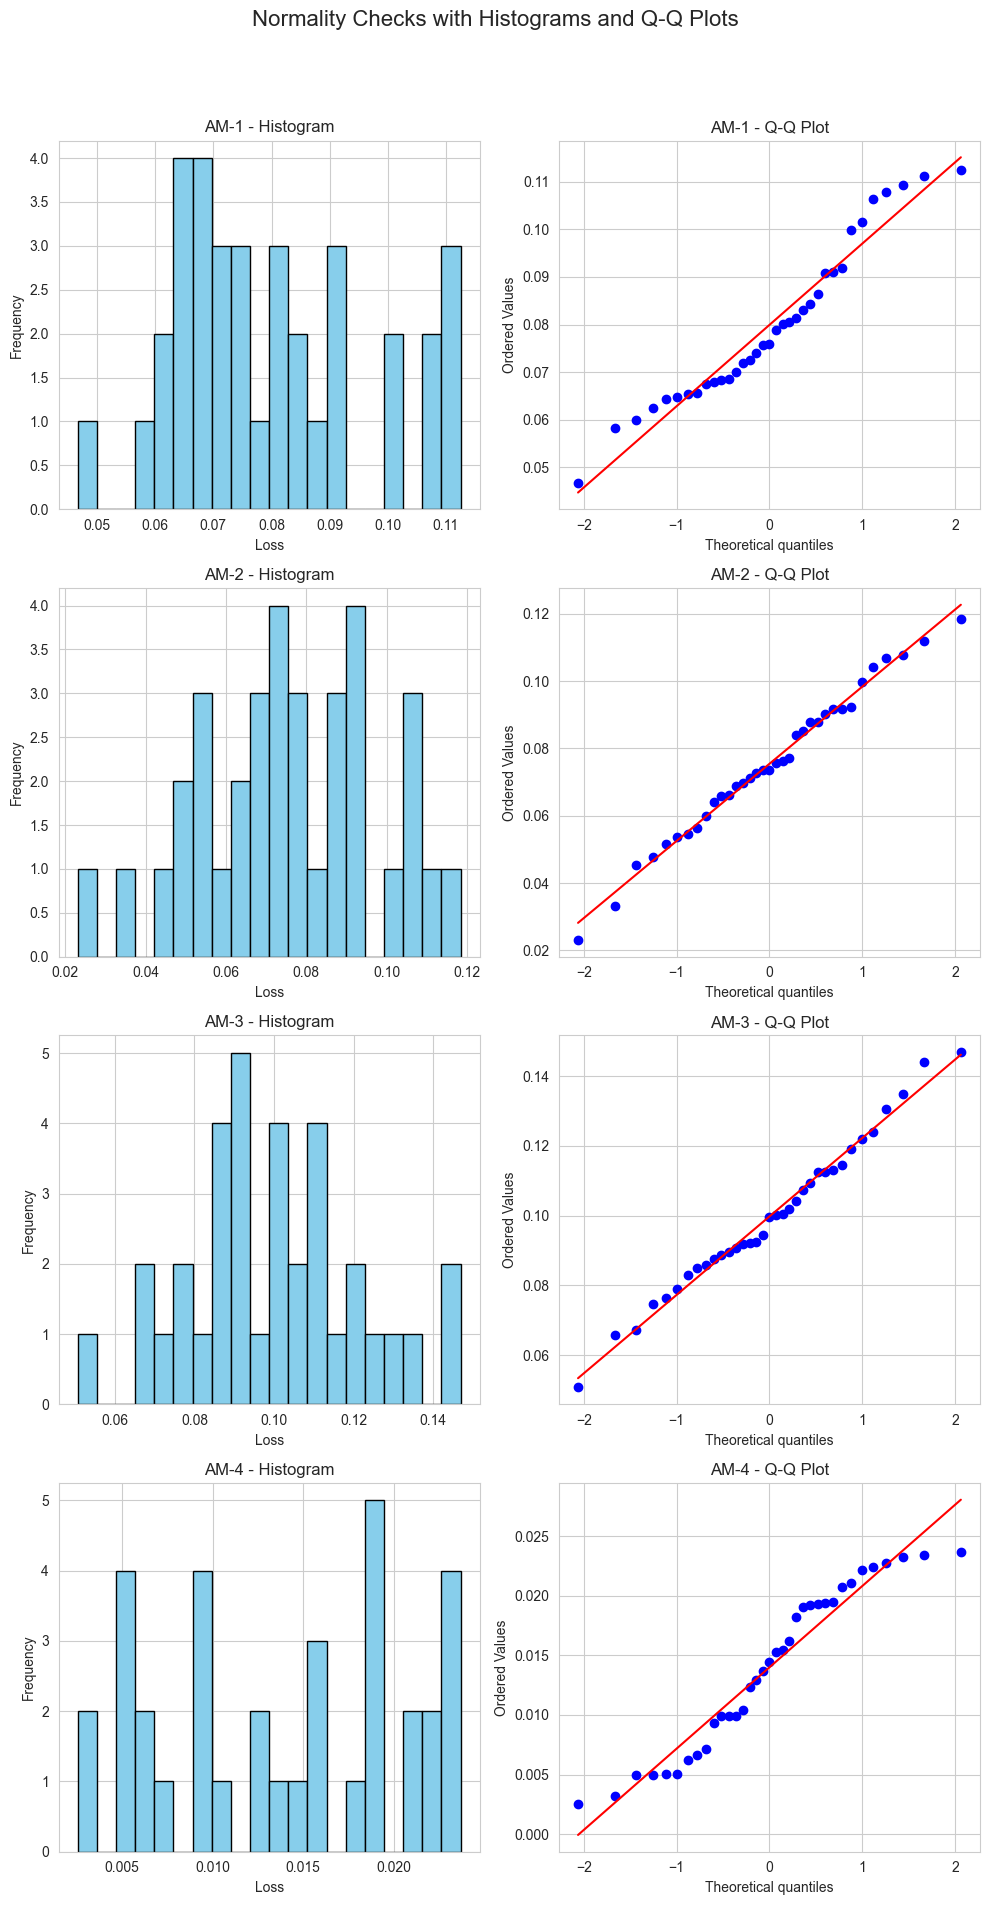

In [6]:
groups = df['group'].unique()

fig, axes = plt.subplots(nrows=len(groups), ncols=2, figsize=(10, len(groups)*5))
fig.suptitle('Normality Checks with Histograms and Q-Q Plots', fontsize=16)

for i, group in enumerate(groups):
    data = df[df['group'] == group]['loss']

    axes[i, 0].hist(data, bins=20, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{group} - Histogram')
    axes[i, 0].set_xlabel('Loss')
    axes[i, 0].set_ylabel('Frequency')

    stats.probplot(data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'{group} - Q-Q Plot')
    axes[i, 1].get_lines()[1].set_color('red')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./figures/anova-normality-check.png")
plt.show()

In [7]:
#H_0: data was drawn from a normal distribution.
print("Normality Test Results:")
for group in df['group'].unique():
    stat, p = stats.shapiro(df[df['group'] == group]['loss'])
    print(f"{group}: Statistics={stat}, p-value={p}")

Normality Test Results:
AM-1: Statistics=0.9473236177051617, p-value=0.09376750407728972
AM-2: Statistics=0.9885135164287748, p-value=0.9686461065243843
AM-3: Statistics=0.9879125252759885, p-value=0.9603533109792072
AM-4: Statistics=0.9269784887580342, p-value=0.022769737082128115


#### Homogeneity of Variances

In [10]:
#H_0: all input samples are from populations with equal variances.
print("\nHomogeneity of Variances Test (Levene's Test):")
stat, p = stats.levene(df[df['group'] == 'AM-1']['loss'],
                       df[df['group'] == 'AM-2']['loss'],
                       df[df['group'] == 'AM-3']['loss'],
                       df[df['group'] == 'AM-4']['loss'])
print(f"Statistics={stat}, p-value={p}")


Homogeneity of Variances Test (Levene's Test):
Statistics=8.400378627943706, p-value=3.6628937862495675e-05


### ANOVA Test

In [11]:
#H_0: two or more groups have the same population mean.
f_oneway(base_loss, causal_loss, asym_loss, fourier_loss)

F_onewayResult(statistic=147.40711072218548, pvalue=1.486197704107597e-42)

### Post Hoc Tukey HSD Test

In [12]:
#H_0: all means being compared are from the same population
tukey = pairwise_tukeyhsd(endog=df['loss'], groups=df['group'], alpha=0.05)
print("\nTukey HSD Test Results:")
print(tukey.summary())


Tukey HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  AM-1   AM-2  -0.0045 0.7253 -0.0157  0.0067  False
  AM-1   AM-3   0.0198 0.0001  0.0086  0.0311   True
  AM-1   AM-4  -0.0659    0.0 -0.0772 -0.0547   True
  AM-2   AM-3   0.0243    0.0  0.0131  0.0356   True
  AM-2   AM-4  -0.0614    0.0 -0.0727 -0.0502   True
  AM-3   AM-4  -0.0858    0.0  -0.097 -0.0745   True
----------------------------------------------------


In [14]:
# dump test loss means and stddev
import os
def write(f, group):
   mean = df[df['group'] == group]['loss'].mean()
   stddev = df[df['group'] == group]['loss'].std()
   f.write(f"|{group} | {mean:.4f} | {stddev:.4f}| {os.linesep}")
   
with open('table-test-losses.txt', 'w') as f:
    f.write(f"| attention mechanism | average | stddev |{os.linesep}")
    f.write(f"|--:|--:|--:|{os.linesep}")
    write(f, "AM-1")
    write(f, "AM-2")
    write(f, "AM-3")
    write(f, "AM-4")
    f.write(f"{os.linesep}")
    f.write(f"Table: Test losses for the attention mechanisms \\label{{table:test-losses}}")

